# Exploratory Data Analysis #3: FastText Embedding Visualization

## Extracting and Visualizing Pre-Trained *FastText* Embeddings to Show Real vs Fake News Patterns

*FastText* is a useful library developed by Facebook AI Research lab made for [converting textual data to dense (i.e. no zero-entry) embeddings](https://medium.com/@93Kryptonian/word-embedding-using-fasttext-62beb0209db9). In contrast, TF-IDF vectorization produces very sparse vectors, based on normalizde frequency counts of words and word n-grams, that often fail to capture contextual dependencies between words. *FastText** extends the foundational *word2vec* algorithm by breaking words down into character n-grams rather than relying solely on word tokens. Capturing these subword patterns thus makes it more adaptable to unseen "out-of-vocabulary" words. Embeddings can either be trained using your own dataset, or can be created using a pre-trained model. In this section, I will encode the news texts for real vs fake news categories using the standard FastText pre-trained (on *Common Crawl* and *Wikipedia*) [**cc.en.300.bin** model](https://fasttext.cc/docs/en/crawl-vectors.html), which outputs numeric word vectors of length 300, and used a context-window of size 5: these hyperparameters strike a balance between retaining sufficient information and computational efficiency. While we can also train our own embeddings using the labelled news datasets, the pre-trained model provides a decent and fast foundation for initial exploration of word patterns between fake and real news at this stage of the project.

Using dimensionality reduction (to condense the 300-dimensional vectors into 2D representations) and visualization can help us understand how fake news and real news are clustered differently in the vector space, and to analyze whether there is indeed a clear difference in fake news and real news in the combined, five-shot and zero-shot datasets, which contain samples from extremely diverse and domain-specific datasets. By visualizing the *FastText* embeddings, we can see how well the pre-trained model embeddings separate real from fake news samples across these challenging datasets.


In [1]:
# Import the required libraries
import os

# Basic text data analysis libraries:
import pandas as pd
import numpy as np
from tqdm import tqdm
# Show the progress of applying different functions for processing an entire column in pandas
tqdm.pandas()
import string
import time

# Basic NLP libraries and downloading NLTK packages:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
# Download VADER for sent-analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Get a set of stopwords for English (set = more efficient processing)
stopwords_set = set(stopwords.words('english'))
import spacy
# Emotion lexicon for 8 categories of emotions
from nrclex import NRCLex
# TextBlob for subjectivity scores
from textblob import TextBlob
# spellchecker for getting counts of misspelled words
from spellchecker import SpellChecker

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import textwrap 

# Important library for decoding text files
import chardet

# FastText embeddings
import fasttext
import fasttext.util

# Import libraries for visualizing FastText embeddings
import ast
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
# "Kernel density estimation is a way to estimate the probability density function (PDF) of a random variable"
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
from scipy.stats import gaussian_kde

[nltk_data] Downloading package punkt to /Users/ophelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Load in all of the training datasets for feature extraction and comparison

# Set up the root full-scale dataset path on my machine
root_fullscale_path = "../FPData/"

###################################### FULL-SCALE (Single Dataset) TRAINING DATA ###########################################################
welfake_train_path = os.path.join(root_fullscale_path, "WELFake/clean_all_train_wf.csv")
welfake_test_path = os.path.join(root_fullscale_path, "WELFake/clean_test_wf.csv")

fakeddit_train_path = os.path.join(root_fullscale_path, "Fakeddit/clean_all_train.csv")
fakeddit_test_path = os.path.join(root_fullscale_path, "Fakeddit/clean_test.csv")

constraint_train_path = os.path.join(root_fullscale_path, "Constraint/clean_all_train.csv")
constraint_test_path = os.path.join(root_fullscale_path, "Constraint/clean_test.csv")

politifact_train_path = os.path.join(root_fullscale_path, "PolitiFact/clean_all_train_pf.csv")
politifact_test_path = os.path.join(root_fullscale_path, "PolitiFact/clean_test_pf.csv")

gossipcop_train_path = os.path.join(root_fullscale_path, "GossipCop/clean_all_train_gc.csv")
gossipcop_test_path = os.path.join(root_fullscale_path, "GossipCop/clean_test_gc.csv")

root_fewshot_path = "../FPData/CleanFewShotDatasets_withoutValSets/"
welfake_target_fiveshot_path = os.path.join(root_fewshot_path, "five_shot_train_data_except_welfake.csv")
fakeddit_target_fiveshot_path = os.path.join(root_fewshot_path, "five_shot_train_data_except_fakeddit.csv")
constraint_target_fiveshot_path = os.path.join(root_fewshot_path, "five_shot_train_data_except_constraint.csv")
politifact_target_fiveshot_path = os.path.join(root_fewshot_path, "five_shot_train_data_except_politifact.csv")
gossipcop_target_fiveshot_path = os.path.join(root_fewshot_path, "five_shot_train_data_except_gossipcop.csv")

root_zeroshot_path = "../FPData/CleanZeroShotDatasets_withoutValSets/"
welfake_target_zeroshot_path = os.path.join(root_zeroshot_path, "zero_shot_train_data_except_welfake.csv")
fakeddit_target_zeroshot_path = os.path.join(root_zeroshot_path, "zero_shot_train_data_except_fakeddit.csv")
constraint_target_zeroshot_path = os.path.join(root_zeroshot_path, "zero_shot_train_data_except_constraint.csv")
politifact_target_zeroshot_path = os.path.join(root_zeroshot_path, "zero_shot_train_data_except_politifact.csv")
gossipcop_target_zeroshot_path = os.path.join(root_zeroshot_path, "zero_shot_train_data_except_gossipcop.csv")

# Full-scale train datasets
wf_df_train = pd.read_csv(welfake_train_path)
fe_df_train = pd.read_csv(fakeddit_train_path)
ct_df_train = pd.read_csv(constraint_train_path)
pf_df_train = pd.read_csv(politifact_train_path)
gc_df_train = pd.read_csv(gossipcop_train_path)

# Full-scale test datasets
wf_df_test = pd.read_csv(welfake_test_path)
fe_df_test = pd.read_csv(fakeddit_test_path)
ct_df_test = pd.read_csv(constraint_test_path)
pf_df_test= pd.read_csv(politifact_test_path)
gc_df_test = pd.read_csv(gossipcop_test_path)

# Concatenated (train AND test) full-scale datasets
wf_df = pd.concat([wf_df_train, wf_df_test], ignore_index=True)
fe_df = pd.concat([fe_df_train, fe_df_test], ignore_index=True)
ct_df = pd.concat([ct_df_train, ct_df_test], ignore_index=True)
pf_df = pd.concat([pf_df_train, pf_df_test], ignore_index=True)
gc_df = pd.concat([gc_df_train, gc_df_test], ignore_index=True)

# Five-shot train datasets
wf_target_fiveshot_df = pd.read_csv(welfake_target_fiveshot_path)
fe_target_fiveshot_df = pd.read_csv(fakeddit_target_fiveshot_path)
ct_target_fiveshot_df = pd.read_csv(constraint_target_fiveshot_path)
pf_target_fiveshot_df = pd.read_csv(politifact_target_fiveshot_path)
gc_target_fiveshot_df = pd.read_csv(gossipcop_target_fiveshot_path)

# Zero-shot train datasets
wf_target_zeroshot_df = pd.read_csv(welfake_target_zeroshot_path)
fe_target_zeroshot_df = pd.read_csv(fakeddit_target_zeroshot_path)
ct_target_zeroshot_df = pd.read_csv(constraint_target_zeroshot_path)
pf_target_zeroshot_df = pd.read_csv(politifact_target_zeroshot_path)
gc_target_zeroshot_df = pd.read_csv(gossipcop_target_zeroshot_path)

In [6]:
# Split datasets into real vs fake news for comparing differences between features

# WELFake
wf_df_real = wf_df[wf_df["label"] == 0]
wf_df_fake = wf_df[wf_df["label"] == 1]

# Fakeddit
fe_df_real = fe_df[fe_df["label"] == 0]
fe_df_fake = fe_df[fe_df["label"] == 1]

# Constraint
ct_df_real = ct_df[ct_df["label"] == 0]
ct_df_fake = ct_df[ct_df["label"] == 1]

# PolitiFact
pf_df_real = pf_df[pf_df["label"] == 0]
pf_df_fake = pf_df[pf_df["label"] == 1]

# GossipCop
gc_df_real = gc_df[gc_df["label"] == 0]
gc_df_fake = gc_df[gc_df["label"] == 1]

# Five-shot: WELFake target
wf_tgt_5shot_df_real = wf_target_fiveshot_df[wf_target_fiveshot_df["label"] == 0]
wf_tgt_5shot_df_fake = wf_target_fiveshot_df[wf_target_fiveshot_df["label"] == 1]

# Five-shot: Fakeddit target
fe_tgt_5shot_df_real = fe_target_fiveshot_df[fe_target_fiveshot_df["label"] == 0]
fe_tgt_5shot_df_fake = fe_target_fiveshot_df[fe_target_fiveshot_df["label"] == 1]

# Five-shot: Constraint target
ct_tgt_5shot_df_real = ct_target_fiveshot_df[ct_target_fiveshot_df["label"] == 0]
ct_tgt_5shot_df_fake = ct_target_fiveshot_df[ct_target_fiveshot_df["label"] == 1]

# Five-shot: PolitiFact target
pf_tgt_5shot_df_real = pf_target_fiveshot_df[pf_target_fiveshot_df["label"] == 0]
pf_tgt_5shot_df_fake = pf_target_fiveshot_df[pf_target_fiveshot_df["label"] == 1]

# Five-shot: GossipCop target
gc_tgt_5shot_df_real = gc_target_fiveshot_df[gc_target_fiveshot_df["label"] == 0]
gc_tgt_5shot_df_fake = gc_target_fiveshot_df[gc_target_fiveshot_df["label"] == 1]

# Zero-shot: WELFake target
wf_tgt_0shot_df_real = wf_target_zeroshot_df[wf_target_zeroshot_df["label"] == 0]
wf_tgt_0shot_df_fake = wf_target_zeroshot_df[wf_target_zeroshot_df["label"] == 1]

# Zero-shot: Fakeddit target
fe_tgt_0shot_df_real = fe_target_zeroshot_df[fe_target_zeroshot_df["label"] == 0]
fe_tgt_0shot_df_fake = fe_target_zeroshot_df[fe_target_zeroshot_df["label"] == 1]

# Zero-shot: Constraint target
ct_tgt_0shot_df_real = ct_target_zeroshot_df[ct_target_zeroshot_df["label"] == 0]
ct_tgt_0shot_df_fake = ct_target_zeroshot_df[ct_target_zeroshot_df["label"] == 1]

# Zero-shot: PolitiFact target
pf_tgt_0shot_df_real = pf_target_zeroshot_df[pf_target_zeroshot_df["label"] == 0]
pf_tgt_0shot_df_fake = pf_target_zeroshot_df[pf_target_zeroshot_df["label"] == 1]

# Zero-shot: GossipCop target
gc_tgt_0shot_df_real = gc_target_zeroshot_df[gc_target_zeroshot_df["label"] == 0]
gc_tgt_0shot_df_fake = gc_target_zeroshot_df[gc_target_zeroshot_df["label"] == 1]

In [19]:
# Create a class for extracting and plotting pre-trained FastText embeddings
class EmbeddingsExtractorAndAnalyzer:
    def __init__(self, purpose="extracting_embeddings"):

        # Do this so that model is only loaded (very RAM-heavy and often crashes the kernel) if class
        # is to be used for extracting embeddings rather than plotting them. Didn't know this would crash so much...
        if purpose=="extracting_embeddings":
            # Load in the pre-trained FastText model cc.en.300.bin (takes some time)
            start_time = time.time() # Time how long it takes
    
            # Download the FastText model only if it doesn't already exist by passing in the if_exists flag
            fasttext.util.download_model("en", if_exists='ignore')
            self.fasttext_model = fasttext.load_model("cc.en.300.bin")
    
            # Get the end time after loading the model
            end_time = time.time()
            time_elapsed = end_time - start_time
            # Calculate time elapsed in minutes and seconds
            minutes = int(time_elapsed // 60)
            seconds = int(time_elapsed % 60)
            
            # Print the time taken in minutes and seconds
            print(f"FastText pre-trained model loaded in {minutes:02} minutes and {seconds:02} seconds.")

    
    # Ref: https://fasttext.cc/docs/en/python-module.html
    def getSubwordTokens(self, text):
        """
        Helper function that takes in a text and extracts subword tokens using the FastText model.
        Input Parameters:
            text (str): text for which to extract subword tokens
        Output:
            all_tokens (list of str): List of words and subwords for the input text
        """
        # Split text into word tokens
        word_tokens = word_tokenize(text)
        all_token_indices = []  # Create a list to store subword token indexes for fasttext embedding lookup
        for token in word_tokens:
            word_and_subword_tokens, token_indices = self.fasttext_model.get_subwords(token) # This returns a list of tokens and indexes
            # Add indexes to the list
            all_token_indices.extend(token_indices)

        return all_token_indices  # Return the list of word and subword tokens

    def getEmbedding(self, text):
        """
        Helper function that converts a text into a FastText embedding based on subword tokenization.
        Input Parameters:
            text (str): Text to convert into a dense FastText embedding.
        Output:
            document_embedding (np.array): The FastText embedding for the text.
        """
        token_indices = self.getSubwordTokens(text)  # Get subword token indices for the text
        token_embeddings = []  # List to store embeddings for each token
    
        # Get embeddings for each token index (representing a word or subword)
        for token_index in token_indices:
            if token_index:  # Ensure the token is not empty
                try:
                    token_embedding = self.fasttext_model.get_input_vector(token_index)  # Get embedding for the token
                    token_embeddings.append(token_embedding)  # Append the embedding to the list
                except Exception as e:
                    print(f"Error with token index {token_index}: {e}")
    
        # Aggregate the embeddings for the whole document using the mean
        if token_embeddings:
            document_embedding = np.mean(token_embeddings, axis=0)  # Take the mean of all token embeddings
        else:
            document_embedding = np.zeros(self.fasttext_model.get_dimension())  # Return a zero vector if no valid embeddings
    
        return document_embedding  # Return the aggregated document embedding


        
    def generateDatasetTextEmbeddings(self, df, dataset_name, save_path="../FPData/UnsupervisedFastTextEmbeddingDFs"):
        """
        Takes in a news DataFrame with a "text" column and creates a new column "ft_embedding" containing
        the pre-trained cc.en.300.bin FastText embeddings with subword tokenization.

        Input Parameters:
            df (pd.DataFrame): A news DataFrame containing a "text" column.
        """

        # Make a deep copy of original DF
        embed_df = df.copy()
        
        # Initialize tqdm progress bar
        tqdm.pandas(desc=f"Calculating FastText Embeddings for {dataset_name}")
        
        # Apply the embedding function with progress_apply
        embed_df["ft_embedding"] = embed_df["text"].progress_apply(lambda text: self.getEmbedding(text))

        dataset_path = f"{os.path.join(save_path, dataset_name)}.csv"
        embed_df.to_csv(dataset_path, index=False, chunksize=1000) # Save in chunks due to large file size

        print(f"Embedding DataFrame saved to {dataset_path}")

        return embed_df  # Return the DataFrame with embeddings column
        

    def plotRealVsFakeEmbeddings(self, df_pair, dataset_name):
        """
            Plots visualizations (scatter-plots) for real vs fake news embeddings side-by-side for a dataset.
            
            Input Parameters:
                df_pair: A tuple containing a real and fake news DataFrame for a dataset
                dataset_names (str): A description of the dataset.
        """

        # Setup the subplot grid: 1 row, 2 cols
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Flatten the axes for easier indexing
        axes = axes.flatten() 

        real_df = df_pair[0] # Real news DataFrame
        fake_df = df_pair[1] # Fake news DataFrame

        # Convert the embeddings from strings with space-separators into required NumPy arrays for both dataframes
        real_news_embeddings = np.vstack([
            self.convertSavedEmbeddingStringToNumPyArray(embedding_formatted_as_string) 
            for embedding_formatted_as_string in real_df["ft_embedding"].values
        ])
        
        fake_news_embeddings = np.vstack([
            self.convertSavedEmbeddingStringToNumPyArray(embedding_formatted_as_string) 
            for embedding_formatted_as_string in fake_df["ft_embedding"].values
        ])

        # Dimensionality reduction for real news data: use PCA for the dim-reduction method to reduce embeds to 2D
        real_news_reducer = PCA(n_components=2, random_state=5) # Set random_state for reproducibility
        fake_news_reducer = PCA(n_components=2, random_state=5)

        # Apply dimensionality reduction to embeddings
        real_news_embeddings2d = real_news_reducer.fit_transform(real_news_embeddings) # Real news
        fake_news_embeddings2d = fake_news_reducer.fit_transform(fake_news_embeddings) # Fake news

        # Compute density using Gaussian KDE
        real_news_density = self.computeGaussianKernelDensityEstimate(
            real_news_embeddings2d [:, 0],
            real_news_embeddings2d [:, 1] # Extract all x- and y-dims
        ) 
        fake_news_density = self.computeGaussianKernelDensityEstimate(
            fake_news_embeddings2d[:, 0],
            fake_news_embeddings2d[:, 1]
        )

        # Create new DataFrames for the reduced 2D embedding dimensions
        real_news_2d_embedding_df = pd.DataFrame(real_news_embeddings2d, columns=["x", "y"])
        real_news_2d_embedding_df["density"] = real_news_density
        fake_news_2d_embedding_df = pd.DataFrame(fake_news_embeddings2d, columns=["x", "y"])
        fake_news_2d_embedding_df["density"] = fake_news_density

        # Plot real news reduced embeddings using the Seaborn scatterplot
        sns.scatterplot(
            data=real_news_2d_embedding_df,
            x="x", y='y',
            hue="density", palette="viridis",
            ax=axes[0], # Extract the right axes index (row) and column for this dataset
            color="blue", alpha=0.7, s=40
        )
        axes[0].set_title(f"Dataset {dataset_name}: Real News (PCA)")
        axes[0].set_xlabel("Dimension 1")
        axes[0].set_ylabel("Dimension 2")
        axes[0].legend(title="Density", loc="best")

        # Plot fake news embeddings
        sns.scatterplot(
                data=fake_news_2d_embedding_df,
                x="x", y='y', 
                hue="density", palette="plasma",
                ax=axes[1], # Extract the right axes index (row) and column for this dataset
                color="blue", alpha=0.7, s=40
            )
        axes[1].set_title(f"Dataset {dataset_name}: Fake News (PCA)")
        axes[1].set_xlabel("Dimension 1")
        axes[1].set_ylabel("Dimension 2")
        axes[1].legend(title="Density", loc="best")
            
        plt.tight_layout()
        plt.show()
             

    def convertSavedEmbeddingStringToNumPyArray(self, embedding_string):
        """
            A helper function which takes the saved embedding format (as a string in a .csv file),
            and converts it into a NumPy array for plotting.
        """
        # Remove any extra brackets from the beginning and end of the non-comma-separated embedding string
        cleaned_embedding = embedding_string.strip("[]")
        # Convert to NumPy array using the .fromstring method, using space as separator as no commas
        # were unfortunately used, making this a more complex task
        return np.fromstring(cleaned_embedding, sep=' ')

    def computeGaussianKernelDensityEstimate(self, x_dim, y_dim):
        """
            A helper function that estimates Gaussian kernel density of a random variable, 
            for color-coded plotting based on density, showing the concentration (density) of data points.
            Helps in visually communicating differences in distribution of real vs fake
            news data points.
            
            Input Parameters:
                x_dim: NumPy array of values for the x-dimension of reduced embeddings for a DataFrame
                y_dim: NumPy array of values for the y-dimension of reduced embeddings for a DataFrame

            Output:
                gaussian_kde(xy)(xy): a 1D NumPy array of density values for each point, higher values
                indicate a dense, very concentrated region of points. Can be used for color plotting.
        """
        # Stacks the 1-dim x- and y-arrays into a 2D array vertically to make a single array
        xy = np.vstack([x_dim, y_dim])
        # Estimate the density:
            # 1. gaussian_kde(xy) creates a density estimator for the data points, xy (fits the surface over the points).
            # 2. The next (xy) part computes the density values for every point, returning an array of densities.
        return gaussian_kde(xy)(xy)

In [46]:
ft_extractor = EmbeddingsExtractorAndAnalyzer()

## Extracting the Embeddings

The first step is to generate the subword-embedding for each text/document and store the embedding in a new column in each DataFrame.

This is done by first splitting each news text into a list of word tokens (using word_tokenize from the NLTK library) and then calling the
*.get_subwords* method from the FastText library that returns a list of word-tokens *and* character n-grams for each word, as well as a list of FastText indices for each subword or word token.

Next, the *.get_input_vector* method can be called on each token's index to lookup the pre-trained model's embedding for that token. The embedding is a size 300 (by default) vector of non-zero numbers.

To retrieve the embedding for the whole text, you can then average (using *np.mean*) the resulting 300-length arrays to produce a single 300-length vector representing the news text in numerical format.

The resulting embeddings/vectors can then be reduced in dimensionality using a technique such as PCA, and the reduced 2-dimensional embeddings can be plotted to compare the distribution between real and fake news, to see if there is a clear difference between the two data categories in the reduced vector space.

In [86]:
# Try to see if everything is broken with WELFake first
wf_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_df_real, "WELFake_Real")
wf_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_df_fake, "WELFake_Fake")


alculating FastText Embeddings for WELFake_Real: 100%|█| 34617/34617 [03:40<00:

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Real.csv



alculating FastText Embeddings for WELFake_Fake: 100%|█| 27505/27505 [02:30<00:

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Fake.csv


In [103]:
## Do same for other full-scale DFs, but progress bar keeps crashing so separate into different cells
fe_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_df_real, "Fakeddit_Real")


alculating FastText Embeddings for Fakeddit_Real: 100%|█| 440869/440869 [00:58<

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Real.csv


In [104]:
fe_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_df_fake, "Fakeddit_Fake")


alculating FastText Embeddings for Fakeddit_Fake: 100%|█| 348634/348634 [00:41<

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Fake.csv


In [105]:
ct_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_df_real, "Constraint_Real")


alculating FastText Embeddings for Constraint_Real: 100%|█| 5581/5581 [00:02<00

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Real.csv


In [106]:
ct_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_df_fake, "Constraint_Fake")


alculating FastText Embeddings for Constraint_Fake: 100%|█| 5045/5045 [00:01<00

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Fake.csv


In [107]:
pf_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_df_real, "PolitiFact_Real")


alculating FastText Embeddings for PolitiFact_Real: 100%|█| 349/349 [00:09<00:0

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Real.csv


In [108]:
pf_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_df_fake, "PolitiFact_Fake")


alculating FastText Embeddings for PolitiFact_Fake: 100%|█| 317/317 [00:01<00:0

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Fake.csv


In [109]:
gc_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_df_real, "GossipCop_Real")


alculating FastText Embeddings for GossipCop_Real: 100%|█| 13153/13153 [01:29<0

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Real.csv


In [110]:
gc_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_df_fake, "GossipCop_Fake")


alculating FastText Embeddings for GossipCop_Fake: 100%|█| 4020/4020 [00:24<00:

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Fake.csv


In [111]:
# Now do this for 5-shot target datasets
wf_5shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_tgt_5shot_df_real, "WELFake_Target_5shot_Real")


alculating FastText Embeddings for WELFake_Target_5shot_Real: 100%|█| 373728/37

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Target_5shot_Real.csv


In [112]:
wf_5shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_tgt_5shot_df_fake, "WELFake_Target_5shot_Fake")


alculating FastText Embeddings for WELFake_Target_5shot_Fake: 100%|█| 292205/29

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Target_5shot_Fake.csv


In [113]:
fe_5shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_tgt_5shot_df_real, "Fakeddit_Target_5shot_Real")


alculating FastText Embeddings for Fakeddit_Target_5shot_Real: 100%|█| 34243/34

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Target_5shot_Real.csv


In [114]:
fe_5shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_tgt_5shot_df_fake, "Fakeddit_Target_5shot_Fake")


alculating FastText Embeddings for Fakeddit_Target_5shot_Fake: 100%|█| 25174/25

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Target_5shot_Fake.csv


In [115]:
ct_5shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_tgt_5shot_df_real, "Constraint_Target_5shot_Real")


alculating FastText Embeddings for Constraint_Target_5shot_Real: 100%|█| 392556

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Target_5shot_Real.csv


In [116]:
ct_5shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_tgt_5shot_df_fake, "Constraint_Target_5shot_Fake")


alculating FastText Embeddings for Constraint_Target_5shot_Fake: 100%|█| 308561

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Target_5shot_Fake.csv


In [117]:
pf_5shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_tgt_5shot_df_real, "PolitiFact_Target_5shot_Real")


alculating FastText Embeddings for PolitiFact_Target_5shot_Real: 100%|█| 395677

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Target_5shot_Real.csv


In [118]:
pf_5shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_tgt_5shot_df_fake, "PolitiFact_Target_5shot_Fake")


alculating FastText Embeddings for PolitiFact_Target_5shot_Fake: 100%|█| 311382

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Target_5shot_Fake.csv


In [119]:
gc_5shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_tgt_5shot_df_real, "GossipCop_Target_5shot_Real")


alculating FastText Embeddings for GossipCop_Target_5shot_Real: 100%|█| 387422/

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Target_5shot_Real.csv


In [120]:
gc_5shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_tgt_5shot_df_fake, "GossipCop_Target_5shot_Fake")


alculating FastText Embeddings for GossipCop_Target_5shot_Fake: 100%|█| 309031/

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Target_5shot_Fake.csv


In [121]:
# Now do this for 0-shot target datasets
wf_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_tgt_0shot_df_real, "WELFake_Target_0shot_Real")


alculating FastText Embeddings for WELFake_Target_0shot_Real: 100%|█| 373723/37

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Target_0shot_Real.csv


In [122]:
wf_0shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(wf_tgt_0shot_df_fake, "WELFake_Target_0shot_Fake")


alculating FastText Embeddings for WELFake_Target_0shot_Fake: 100%|█| 292205/29

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/WELFake_Target_0shot_Fake.csv


In [123]:
fe_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_tgt_0shot_df_real, "Fakeddit_Target_0shot_Real")


alculating FastText Embeddings for Fakeddit_Target_0shot_Real: 100%|█| 34241/34

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Target_0shot_Real.csv


In [124]:
fe_0shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_tgt_0shot_df_fake, "Fakeddit_Target_0shot_Fake")


alculating FastText Embeddings for Fakeddit_Target_0shot_Fake: 100%|█| 25171/25

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Target_0shot_Fake.csv


In [125]:
fe_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(fe_tgt_0shot_df_real, "Fakeddit_Target_0shot_Real")


alculating FastText Embeddings for Fakeddit_Target_0shot_Real: 100%|█| 34241/34

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Fakeddit_Target_0shot_Real.csv


In [126]:
ct_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_tgt_0shot_df_real, "Constraint_Target_0shot_Real")


alculating FastText Embeddings for Constraint_Target_0shot_Real: 100%|█| 392551

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Target_0shot_Real.csv


In [127]:
ct_0shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(ct_tgt_0shot_df_fake, "Constraint_Target_0shot_Fake")


alculating FastText Embeddings for Constraint_Target_0shot_Fake: 100%|█| 308561

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/Constraint_Target_0shot_Fake.csv


In [130]:
pf_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_tgt_0shot_df_real, "PolitiFact_Target_0shot_Real")


alculating FastText Embeddings for PolitiFact_Target_0shot_Real: 100%|█| 395673

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Target_0shot_Real.csv


In [129]:
pf_0shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(pf_tgt_0shot_df_fake, "PolitiFact_Target_0shot_Fake")


alculating FastText Embeddings for PolitiFact_Target_0shot_Fake: 100%|█| 311381

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/PolitiFact_Target_0shot_Fake.csv


In [131]:
gc_0shot_real_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_tgt_0shot_df_real, "GossipCop_Target_0shot_Real")


alculating FastText Embeddings for GossipCop_Target_0shot_Real: 100%|█| 387417/

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Target_0shot_Real.csv


In [132]:
gc_0shot_fake_embed_df = ft_extractor.generateDatasetTextEmbeddings(gc_tgt_0shot_df_fake, "GossipCop_Target_0shot_Fake")


alculating FastText Embeddings for GossipCop_Target_0shot_Fake: 100%|█| 309031/

Embedding DataFrame saved to ../FPData/UnsupervisedFastTextEmbeddingDFs/GossipCop_Target_0shot_Fake.csv


In [140]:
gc_0shot_fake_embed_df.head()

original_id                                               text  label  \
0     caseocd                          He knows how she feels...      1   
2        6087  Photo of an old Italian man crying after his h...      1   
4      8jk2z4  The dog responsible for taking down Bin Laden(...      1   
5      854tu7  Rare photo of KGB Agent Vladimir Putin getting...      1   
6      3xjubl       Some Vintage Posters I Got at an Estate Sale      1   

   hasImage                                          image_url  \
0      True                     http://i.imgur.com/YPRdO59.jpg   
2     False                                                NaN   
4     False                                                NaN   
5     False                                                NaN   
6      True  https://external-preview.redd.it/JcqM2C3Tp8eXj...   

  original_dataset                                       ft_embedding  
0         Fakeddit  [-0.0017085696, 0.020383816, 0.020350683, 0.02...  
2       Constraint  [0.02982074, 0.01739831, -0.0023845518, 0.0337...  
4         Fakeddit  [-0.012501775, 0.0023914438, 0.0018686122, 0.0...  
5         Fakeddit  [0.020832993, -0.005887098, 0.013553938, 0.023...  
6         Fakeddit  [0.027123008, 0.02439284, -0.00094980496, -0.0...

In [3]:
# Load in the datasets because the kernel keeps crashing every few minutes
load_path = "../FPData/UnsupervisedFastTextEmbeddingDFs"

# Load in the full-scale DataFrames
wf_real_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Real.csv"))
wf_fake_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Fake.csv"))
fe_real_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Real.csv"))
fe_fake_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Fake.csv"))
ct_real_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Real.csv"))
ct_fake_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Fake.csv"))
pf_real_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Real.csv"))
pf_fake_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Fake.csv"))
gc_real_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Real.csv"))
gc_fake_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Fake.csv"))

In [4]:
# Load in the five-shot DataFrames step-by-step as they're so large, it often crashes in the middle, so better to track progress
wf_5shot_real_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Target_5shot_Real.csv"))
wf_5shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Target_5shot_Fake.csv"))

In [5]:
fe_5shot_real_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Target_5shot_Real.csv"))
fe_5shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Target_5shot_Fake.csv"))

In [6]:
ct_5shot_real_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Target_5shot_Real.csv"))
ct_5shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Target_5shot_Fake.csv"))

In [7]:
pf_5shot_real_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Target_5shot_Real.csv"))
pf_5shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Target_5shot_Fake.csv"))

In [8]:
gc_5shot_real_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Target_5shot_Real.csv"))
gc_5shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Target_5shot_Fake.csv"))

In [9]:
# Load in the zero-shot DataFrames
wf_0shot_real_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Target_0shot_Real.csv"))
wf_0shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"WELFake_Target_0shot_Fake.csv"))

In [10]:
fe_0shot_real_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Target_0shot_Real.csv"))
fe_0shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"Fakeddit_Target_0shot_Fake.csv"))

In [11]:
ct_0shot_real_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Target_0shot_Real.csv"))
ct_0shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"Constraint_Target_0shot_Fake.csv"))

In [12]:
pf_0shot_real_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Target_0shot_Real.csv"))
pf_0shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"PolitiFact_Target_0shot_Fake.csv"))

In [13]:
gc_0shot_real_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Target_0shot_Real.csv"))
gc_0shot_fake_embed_df = pd.read_csv(os.path.join(load_path,"GossipCop_Target_0shot_Fake.csv"))

In [15]:
# Create a list of tuples storing real news and fake news DataFrames per full-scale scenario dataset
list_of_df_tuples_fullscale = [
    (wf_real_embed_df, wf_fake_embed_df),
    (fe_real_embed_df, fe_fake_embed_df),
    (ct_real_embed_df, ct_fake_embed_df),
    (pf_real_embed_df, pf_fake_embed_df),
    (gc_real_embed_df, gc_fake_embed_df),
    
]
# Create list of full-scale dataset names for titles when plotting
dataset_names_fullscale = [
    "WELFake", "Fakeddit", "Constraint", "PolitiFact", "GossipCop",
]

# Create a list of tuples storing real news and fake news DataFrames per five-shot scenario dataset
list_of_df_tuples_five_shot = [
    (wf_5shot_real_embed_df, wf_5shot_fake_embed_df),
    (fe_5shot_real_embed_df, fe_5shot_fake_embed_df),
    (ct_5shot_real_embed_df, ct_5shot_fake_embed_df),
    (pf_5shot_real_embed_df, pf_5shot_fake_embed_df),
    (gc_5shot_real_embed_df, gc_5shot_fake_embed_df)
    
]
# Create list of five-shot dataset names for titles when plotting
dataset_names_five_shot = [
    "5-Shot WELFake Target", "5-Shot Fakeddit Target", "5-Shot Constraint Target",
    "5-Shot PolitiFact Target", "5-Shot GossipCop Target"
]

# Create a list of tuples storing real news and fake news DataFrames per zero-shot scenario dataset
list_of_df_tuples_zero_shot = [
    (wf_0shot_real_embed_df, wf_0shot_fake_embed_df),
    (fe_0shot_real_embed_df, fe_0shot_fake_embed_df),
    (ct_0shot_real_embed_df, ct_0shot_fake_embed_df),
    (pf_0shot_real_embed_df, pf_0shot_fake_embed_df),
    (gc_0shot_real_embed_df, gc_0shot_fake_embed_df)
]

# Create list of zero-shot dataset names for titles when plotting
dataset_names_zero_shot = [
    "0-Shot WELFake Target", "0-Shot Fakeddit Target", "0-Shot Constraint Target",
    "0-Shot PolitiFact Target", "0-Shot GossipCop Target"
]

## PCA Dimensionality-Reduction and Plotting the Reduced Embedding Vectors for Real vs Fake News using Seaborn Scatterplots with Gaussian Kernel Density Estimates

In [20]:
ft_extractor = EmbeddingsExtractorAndAnalyzer(purpose="plotting")

### Visualization of Full-Scale Scenario Dataset Embeddings: Real vs Fake News

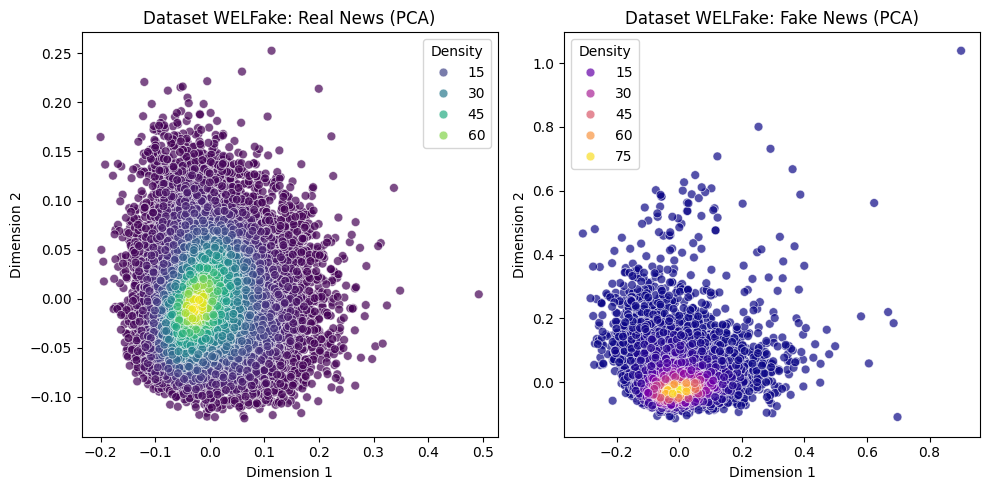

In [21]:
# WELFake dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_fullscale[0], dataset_names_fullscale[0])

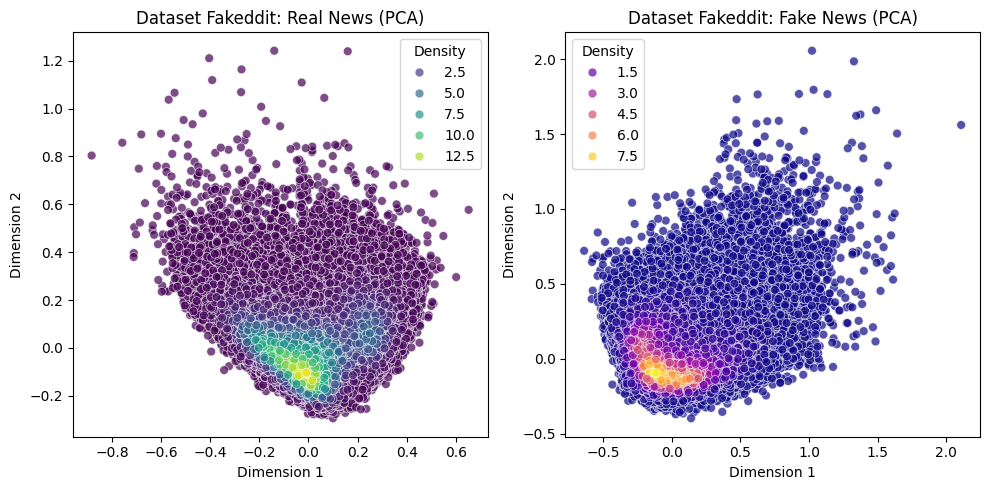

In [22]:
# Fakeddit dataset:
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_fullscale[1], dataset_names_fullscale[1])

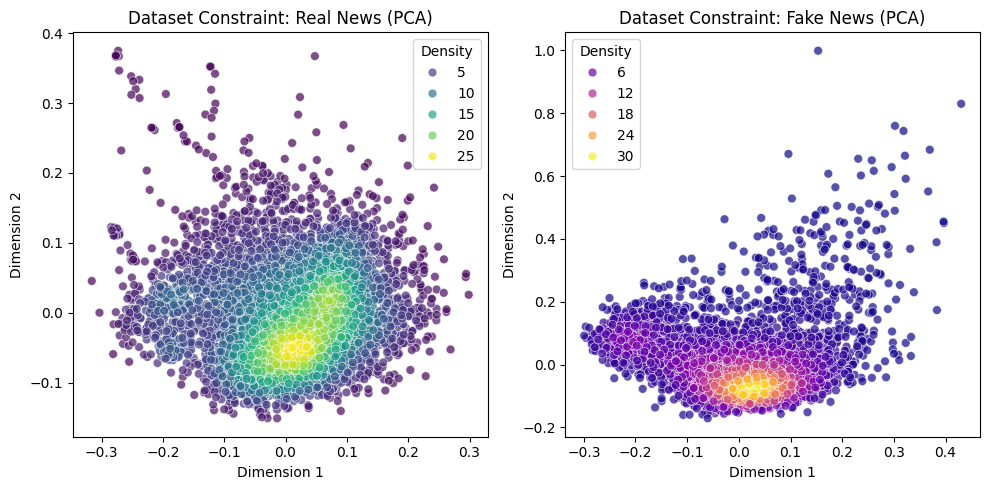

In [26]:
# Constraint dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_fullscale[2], dataset_names_fullscale[2])

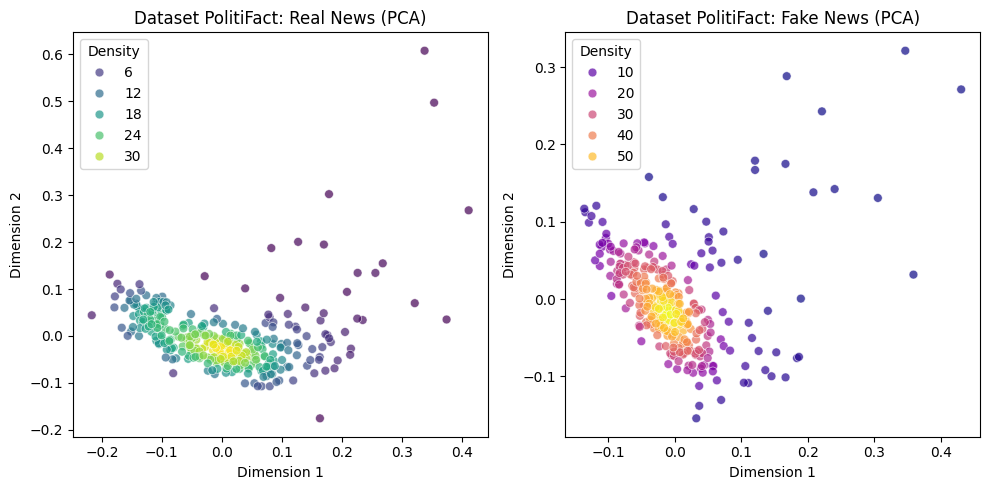

In [27]:
# PolitiFact dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_fullscale[3], dataset_names_fullscale[3])

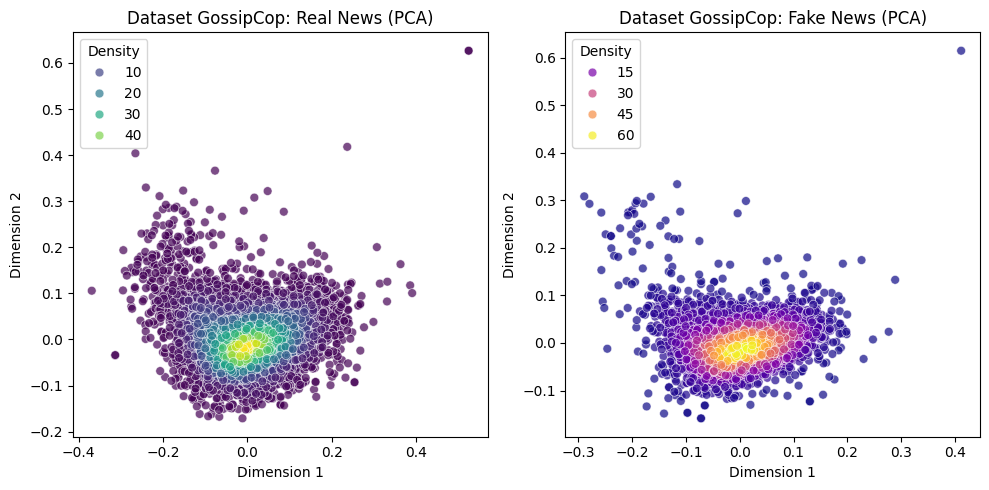

In [28]:
# GossipCop dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_fullscale[4], dataset_names_fullscale[4])

The plots for the full-scale (data from a single dataset) datasets show that for most of the datasets, the 2D embedding space differs significantly between real and fake news, with the exception of the GossipCop dataset, where the patterns seem very similar. This explains why the initial baseline classification results may have been lower for real than for fake news and highlights this dataset as being particularly challenging. This could be due to the fact that for an entertainment-based dataset, word-based textual features for both legitimate news and disinformation could be more similar when compared to political or science datasets, as it is expected that gossip columns frequently also use colloquialisms and informal language. As such, the feature engineering experiments run here may help represent features not solely based on words/sub-words, such as emotion or subjectivity scores, which can improve performance on this difficult dataset.

### Visualization of Five-Shot Scenario Dataset Embeddings: Real vs Fake News

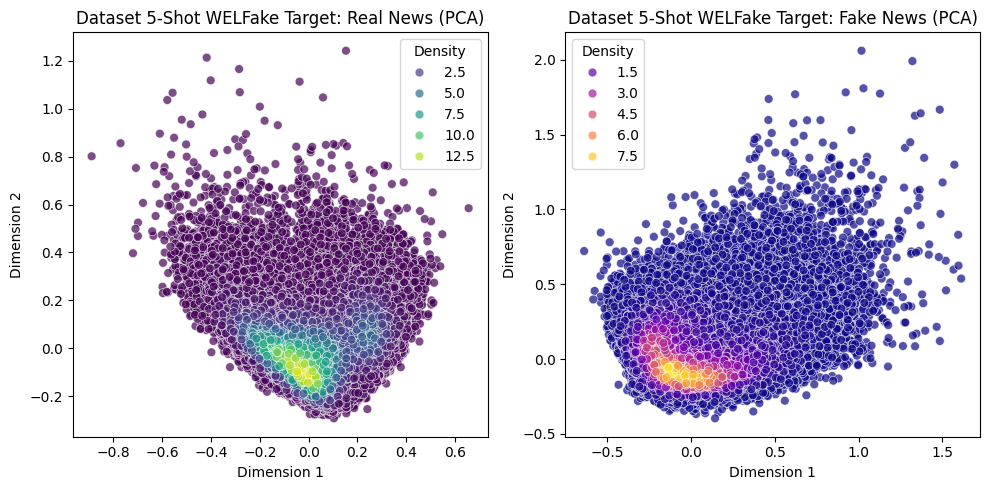

In [29]:
# Five-shot scenario: WELFake target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_five_shot[0], dataset_names_five_shot[0])

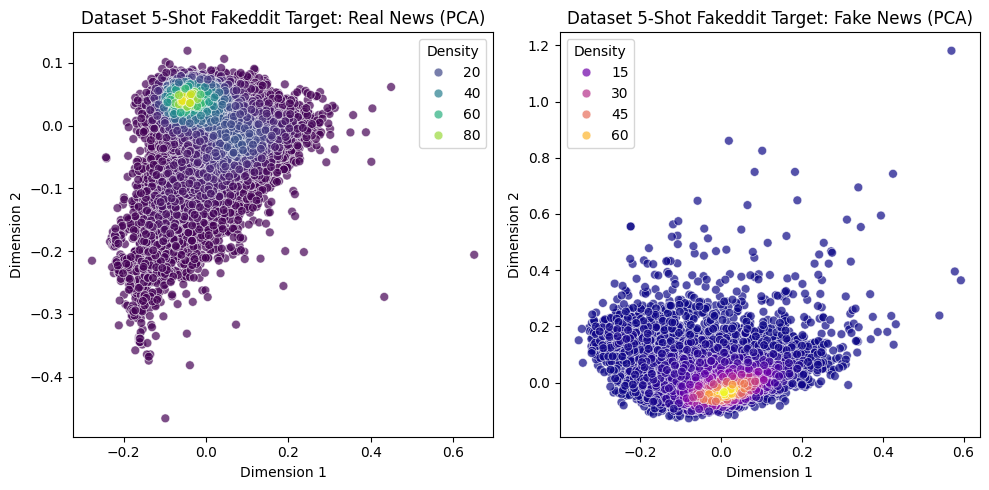

In [30]:
# Five-shot scenario: Fakeddit target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_five_shot[1], dataset_names_five_shot[1])

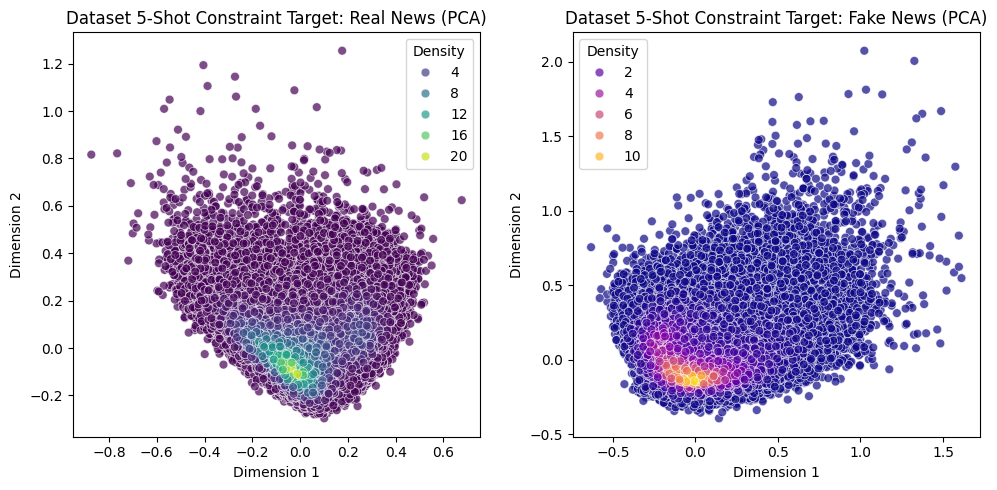

In [31]:
# Five-shot scenario: Constraint target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_five_shot[2], dataset_names_five_shot[2])

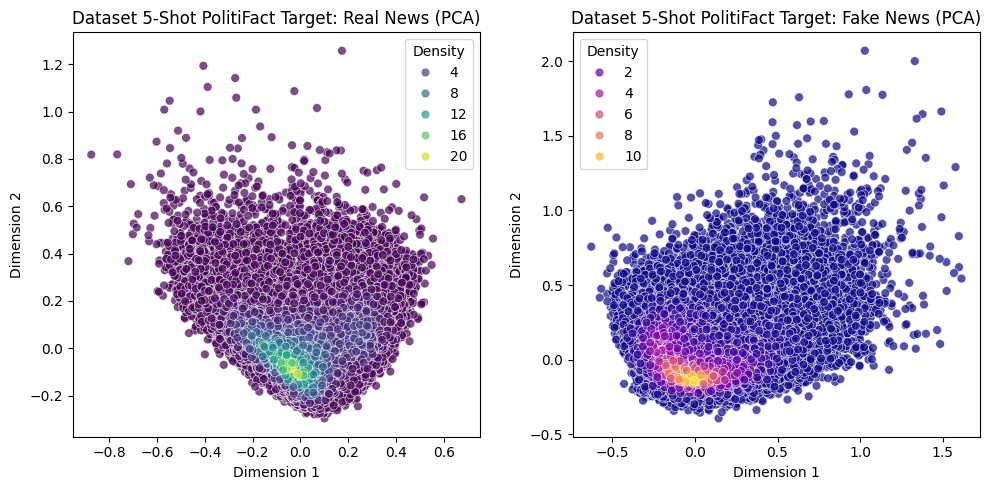

In [32]:
# Five-shot scenario: PolitiFact target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_five_shot[3], dataset_names_five_shot[3])

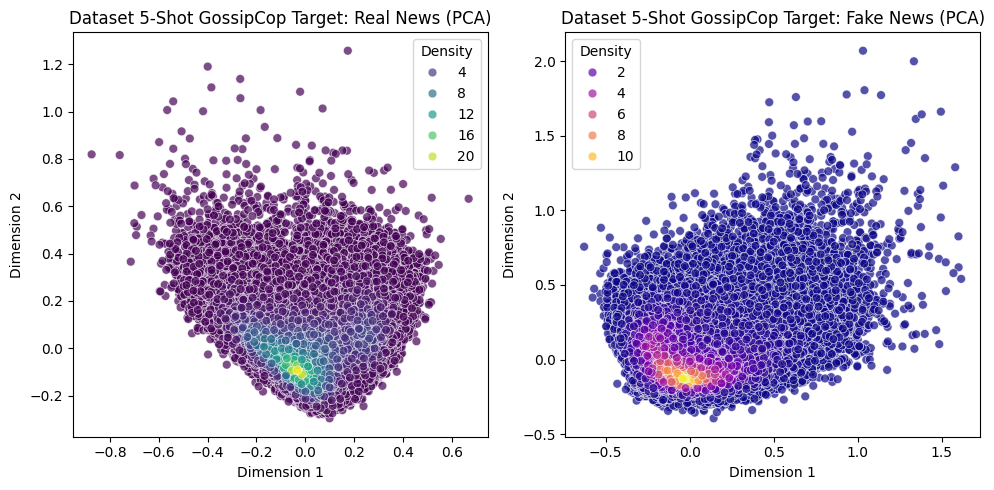

In [33]:
# Five-shot scenario: GossipCop target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_five_shot[4], dataset_names_five_shot[4])

It is interesting that for the five-shot mixed datasets, the shape of the embedding distribution is similar for real news vs fake news for all the datasets (where Fakeddit samples predominate due to the dataset's immense size, despite the short length of its news texts) is quite similar, highlighting a challenge for classifiers to distinguish between real and fake news using word and subword-based features alone. However, when the Fakeddit dataset is removed from the training five-shot datasets, the real news and fake news vector spaces are suddenly starkly difference, indicating a sharp difference between the two news categories. This shows that the Fakeddit dataset is particularly challenging to achieve high performance scores on, perhaps due to the fact that the very short text samples contain insufficient information, and including the multimodal image data is required for improving performance to adequate levels. The same pattern is discernible on the zero-shot, mixed, leave-one-dataset-out embedding plots below: 

### Visualization of Zero-Shot Scenario Dataset Embeddings: Real vs Fake News

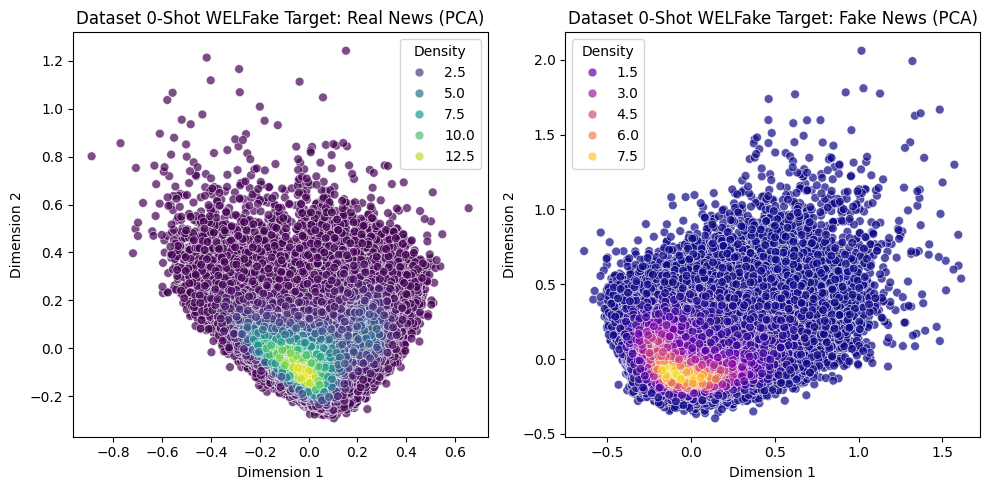

In [34]:
# Zero-shot scenario: WELFake target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_zero_shot[0], dataset_names_zero_shot[0])

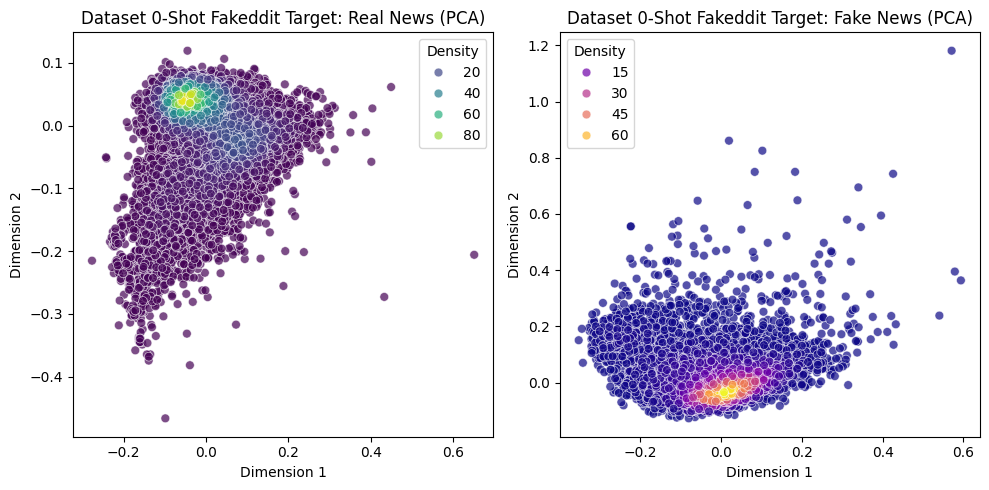

In [35]:
# Zero-shot scenario: Fakeddit target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_zero_shot[1], dataset_names_zero_shot[1])

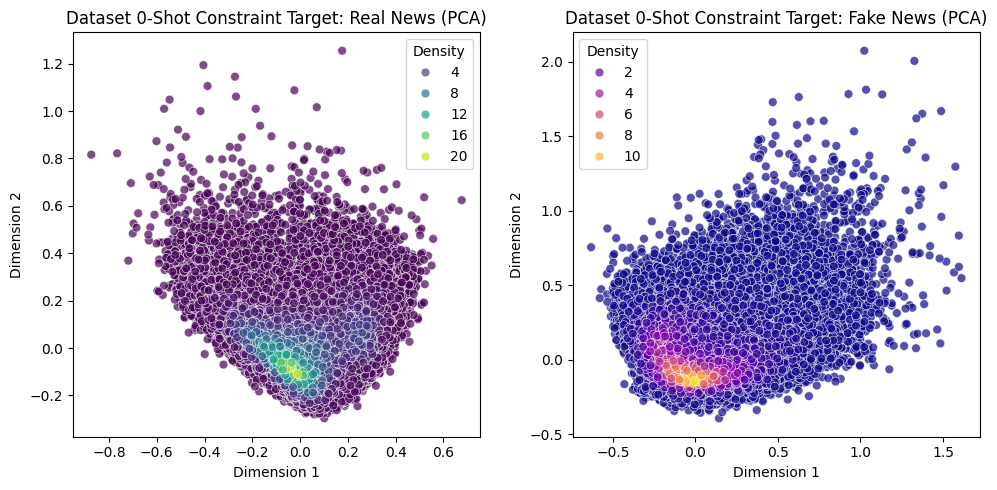

In [36]:
# Zero-shot scenario: Constraint target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_zero_shot[2], dataset_names_zero_shot[2])

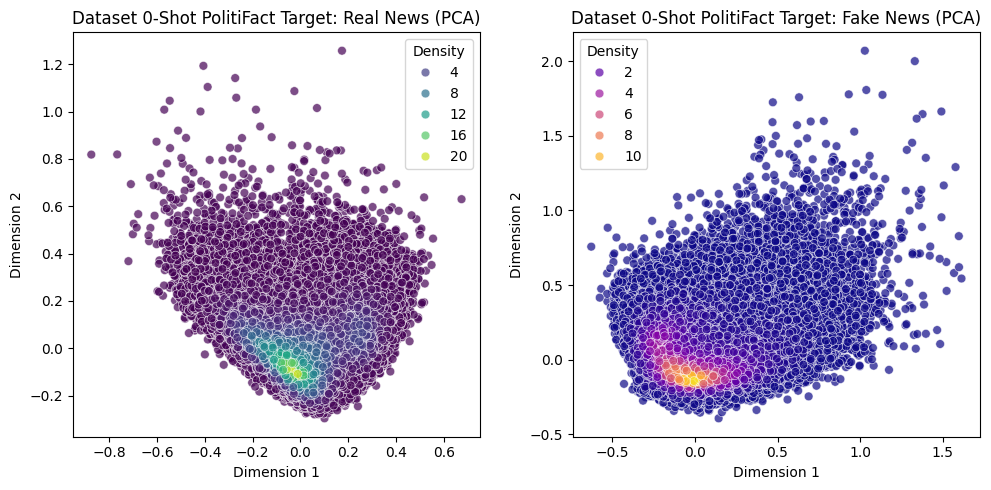

In [37]:
# Zero-shot scenario: PolitiFact target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_zero_shot[3], dataset_names_zero_shot[3])

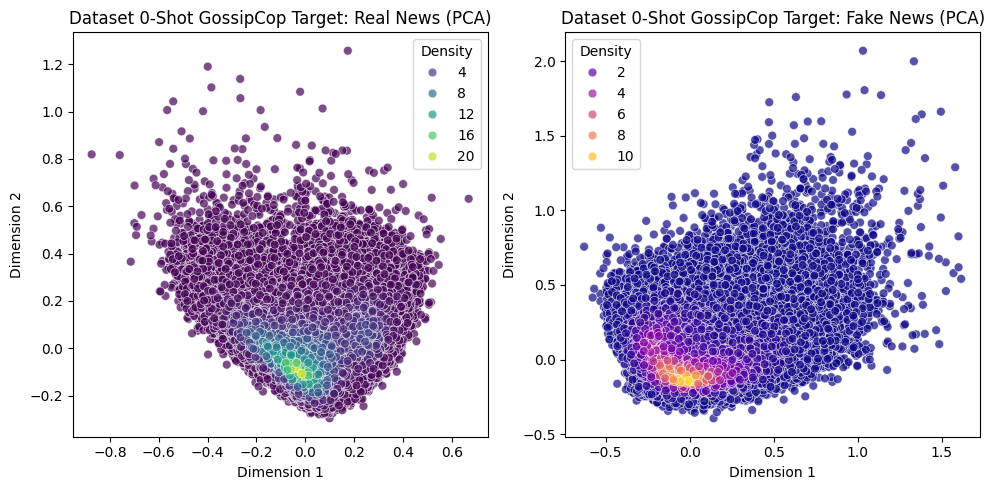

In [38]:
# Zero-shot scenario: GossipCop target dataset
ft_extractor.plotRealVsFakeEmbeddings(list_of_df_tuples_zero_shot[4], dataset_names_zero_shot[4])